In [6]:
import numpy as np
import pandas as pd
# from scipy.integrate import quad
import matplotlib.pyplot as plt
import os

# Hyperparameters:
L1 = 10.0  # L1 regularization
L2 = 10.0  # L2 regularization
L = 0.2  # decay kernel parameter

feature_num = 2  # age, weight


# Helper functions
# decay kernel
def g(t):
    return L * np.exp(-L * t)


def G(t):
    return 1 - np.exp(-L * t)


class cHawk:
    def __init__(self, train_data):
        self.intensity = np.vectorize(self._intensity)

        # load train_data
        self.patients = set(train_data["subject_id"])
        self.diseases = set(train_data["primary"])
        D = max(self.diseases) + 1  # disease number
        self.D = D

        self.f = dict()
        self.t = dict()
        self.d = dict()
        for i in self.patients:
            s = train_data[train_data["subject_id"] == i]

            self.f[i] = s[["age", "weight"]].values
            self.t[i] = s["age"].values
            self.d[i] = s["primary"].values

        # parameters initialization
        self.A = np.random.rand(D, D)  # subject to A >= 0
        self.u = np.random.rand(D, feature_num)  # subject to u_d >= 0
        self.u /= 10

        self.vis = np.zeros_like(self.A)

        # visualization
        self.loss_draw = []
        
#         self.intensity2 = np.vectorize(self._intensity2)

    def _intensity(self, t, i, d):
        j = np.sum(self.t[i] < t)
#         print(j)
#         return self.u[d] @ self.f[i][j - 1] + np.sum(
#             self.A[d][self.d[i][:j]] * g(t - self.t[i][:j])) + 1e-9
        return self.u[d] @ self.f[i][j] + np.sum(
            self.A[d][self.d[i][:j]] * g(t - self.t[i][:j])) + 1e-9
    

    def loss(self):
        res = 0

        # L1, L2 regularization
        res += L1 * np.sum(np.abs(self.A))
        res += 1 / 2 * L2 * np.sum(self.u * self.u)

        # log-likelihood
        log_likelihood = 0
        for i in self.patients:
            T = self.t[i][-1]

            for d in self.diseases:
                disease_d = (self.d[i] == d)
                if self.d[i][0] == d:
                    disease_d[0] = False

                if disease_d.any():
                    tid = self.t[i][disease_d]
                    log_likelihood += np.sum(np.log(self.intensity(tid, i, d)))
#                     print(i, d)
#                     print(tid)
#                     print(np.log(self.intensity(tid, i, d)))
#                     print(np.sum(np.log(self.intensity(tid, i, d))))

                log_likelihood -= self.u[d] @ sum(
                    self.f[i][j] * (self.t[i][j + 1] - self.t[i][j])
                    for j in range(len(self.t[i]) - 1))

                log_likelihood -= np.sum(
                    G(T - self.t[i]) * self.A[d][self.d[i]])

        res -= log_likelihood

        return res

    def grad(self):
        grad_A = np.zeros_like(self.A)
        grad_u = np.zeros_like(self.u)

        # grad_A
        for d in range(self.D):
            for dk in range(self.D):
                # calculate grad_A[d][dk]
                gradient = 0
                for i in self.patients:
                    disease_d = (self.d[i] == d)
                    if self.d[i][0] == d:
                        disease_d[0] = False

                    disease_dk = (self.d[i] == dk)
                    if disease_d.any() and disease_dk.any():
                        tijs = self.t[i][disease_d]
                        tiks = self.t[i][disease_dk]

                        for tij in tijs:
                            intensity_ij = self.intensity(tij, i, d)
                            for tik in tiks:
                                if tik < tij:
                                    self.vis[d][dk] = 1
                                    gradient += g(tij - tik) / intensity_ij

                        T = self.t[i][-1]
                        for tik in tiks:
                            gradient -= G(T - tik)

                gradient = -gradient
#                 gradient += L1 * np.sign(grad_A[d][dk])
                gradient += L1 * np.sign(self.A[d][dk])
                grad_A[d][dk] = gradient

        # grad_u
        for d in range(self.D):
            # calculate grad_u[d]
            gradient = 0
            for i in self.patients:
                disease_d = (self.d[i] == d)
                if self.d[i][0] == d:
                    disease_d[0] = False

                if disease_d.any():
#                     gradient += sum(
#                         self.f[i][disease_d][k] /
#                         self.intensity(self.t[i][disease_d][k], i, d)
#                         for k in range(np.sum(disease_d)))
#                     print(i, d)
#                     print(self.t[i][disease_d])
#                     print(self._intensity2(self.t[i][disease_d], i, d))
                    
#                     print(self.intensity(self.t[i][disease_d], i, d))
                    
#                     gradient += sum(
#                         self.intensity2(self.t[i][disease_d], i, d) / self.intensity(self.t[i][disease_d], i, d) )
                      tijss = self.t[i][disease_d]

                      for tij in tijss:
                          intensity_ij = self.intensity(tij, i, d)
                          jj = np.sum(self.t[i] < tij)
                          gradient += self.f[i][jj] / intensity_ij
                    

                tijs = self.t[i]
                fijs = self.f[i]
                gradient -= sum(fijs[j] * (tijs[j + 1] - tijs[j])
                                for j in range(len(tijs) - 1))

            gradient = -gradient
            gradient += L2 * self.u[d]

            grad_u[d] = gradient
#             print(gradient)

        return grad_A, grad_u

    def project(self, val=0):
        self.A[self.A < 0] = val
        self.u[self.u < 0] = val

    # plain gradient descent
    def GD(self, e=5e-2, lr=1e-5):
        i = 0
        while True:
            # old loss
            old_loss = self.loss()
            print(old_loss, '\t', i)
            self.loss_draw.append(old_loss)

            # update
            grad_A, grad_u = self.grad()
            self.A -= lr * grad_A
            self.u -= lr * grad_u
            self.project()

            # end loop
            if np.abs(self.loss() - old_loss) < e:
                break

            i += 1
            if i > 1000:
                break

        # get rid of irrelavant disease pairs
        self.A[self.vis == 0] = 0

    # momentum gradient descent
    def MGD(self, e=1e-4, lr=1e-5, momentum=0.8):
        # init v_dA, v_du
        v_dA, v_du = self.grad()
        i = 0
        while True:
            # old loss
            old_loss = self.loss()
            print(old_loss, '\t', i)
            self.loss_draw.append(old_loss)

            # update
            grad_A, grad_u = self.grad()

            v_dA = momentum * v_dA + (1 - momentum) * grad_A
            v_du = momentum * v_du + (1 - momentum) * grad_u

            self.A -= lr * v_dA
            self.u -= lr * v_du
            self.project()

            # end loop
            if np.abs(self.loss() - old_loss) < e:
                break

            i += 1
            if i > 2000:
                break

        # get rid of irrelavant disease pairs
        self.A[self.vis == 0] = 0

    # Adagrad
    def Adagrad(self, e=1e-3, lr=1e-2):
        # init squared grad
        grad_A_squared = 0
        grad_u_squared = 0
        i = 0
        while True:
            old_loss = self.loss()
            print(old_loss, '\t', i)
            self.loss_draw.append(old_loss)

            grad_A, grad_u = self.grad()

            grad_A_squared += grad_A * grad_A
            grad_u_squared += grad_u * grad_u

            self.A -= lr * grad_A / (np.sqrt(grad_A_squared) + 1e-7)
            self.u -= lr * grad_u / (np.sqrt(grad_u_squared) + 1e-7)

            self.project()

            # end loop
            if np.abs(self.loss() - old_loss) < e:
                break

            i += 1
            if i > 3000:
                break

        # get rid of irrelavant disease pairs
        self.A[self.vis == 0] = 0

    # Adam
    def Adam(self, e=5e-2, lr=5e-4, beta1=0.9, beta2=0.999):
        # init
        first_moment_A = 0
        first_moment_u = 0
        second_moment_A = 0
        second_moment_u = 0
        i = 1
        while True:
            # old loss
            old_loss = self.loss()
            print(old_loss, '\t', i)
            self.loss_draw.append(old_loss)

            # momentum
            grad_A, grad_u = self.grad()
            first_moment_A = beta1 * first_moment_A + (1 - beta1) * grad_A
            first_moment_u = beta1 * first_moment_u + (1 - beta1) * grad_u
            second_moment_A = beta2 * second_moment_A + (
                1 - beta2) * grad_A * grad_A
            second_moment_u = beta2 * second_moment_u + (
                1 - beta2) * grad_u * grad_u

            # bias correction
            first_unbias_A = first_moment_A / (1 - beta1**i)
            first_unbias_u = first_moment_u / (1 - beta1**i)
            second_unbias_A = second_moment_A / (1 - beta2**i)
            second_unbias_u = second_moment_u / (1 - beta2**i)

            # AdaGrad / RMSProp
            self.A -= lr * first_unbias_A / (np.sqrt(second_unbias_A) + 1e-8)
            self.u -= lr * first_unbias_u / (np.sqrt(second_unbias_u) + 1e-8)

            self.project()

            # end loop
            if np.abs(self.loss() - old_loss) < e:
                break

            i += 1
            if i > 30000:
                break

        # get rid of irrelavant disease pairs
        self.A[self.vis == 0] = 0

    # Alternating Direction Method of Multipliers
    def ADMM(self):
        pass

    def optimize(self):
        self.Adam()

    def save(self,
             file_A='./A_and_u/A.npy',
             file_u='./A_and_u/u.npy',
             file_loss='./A_and_u/loss.npy'):
        np.save(file_A, self.A)
        np.save(file_u, self.u)
        np.save(file_loss, np.array(self.loss_draw))

    def load(self,
             file_A='./A_and_u/A.npy',
             file_u='./A_and_u/u.npy',
             file_loss='./A_and_u/loss.npy'):
        self.A = np.load(file_A)
        self.u = np.load(file_u)
        self.loss_draw = list(np.load(file_loss))

    def draw(self):
        plt.plot(np.array(self.loss_draw))
        plt.show()

    def predict(self):

        pred = dict()
        
        for i in self.patients:
            T = self.t[i][-1]
            max_likelihood = -1
            pred[i] = -1

            for d in self.diseases:
                log_likelihood = 0
                disease_d = (self.d[i] == d)
                if self.d[i][0] == d:
                    disease_d[0] = False

                if disease_d.any():
                    tid = self.t[i][disease_d]
                    log_likelihood += np.sum(np.log(self.intensity(tid, i, d)))

                log_likelihood -= self.u[d] @ sum(
                    self.f[i][j] * (self.t[i][j + 1] - self.t[i][j])
                    for j in range(len(self.t[i]) - 1))

                log_likelihood -= np.sum(
                    G(T - self.t[i]) * self.A[d][self.d[i]])
                
                likelihood = np.exp(log_likelihood)
                print(likelihood)
                if max_likelihood < likelihood:
                    max_likelihood = likelihood
                    pred[i] = d
            print('\n')
            
        return pred


1063.8993895490694 	 1
1059.3664500581824 	 2
1054.8377634439112 	 3
1050.362766990035 	 4
1045.9877722692297 	 5
1041.617628368839 	 6
1037.2526181084063 	 7
1032.9209476865103 	 8
1028.698732675539 	 9
1024.4822882918488 	 10
1020.2719713208405 	 11
1016.0681663084786 	 12
1011.8712880248356 	 13
1007.6846461266804 	 14
1003.5081631135057 	 15
999.3400627662173 	 16
995.1809128259529 	 17
991.0313290288852 	 18
986.8919795815196 	 19
982.7673160109839 	 20
978.6558164296649 	 21
974.5571817684981 	 22
970.4768208284509 	 23
966.4128235708552 	 24
962.3677998361684 	 25
958.3443256933012 	 26
954.3390742192493 	 27
950.3528512187362 	 28
946.387675612857 	 29
942.4480955755405 	 30
938.5397695168158 	 31
934.7786149182142 	 32
931.0416872379428 	 33
927.3272033792191 	 34
923.6310347292463 	 35
919.9499748703979 	 36
916.2797048519017 	 37
912.6152108314154 	 38
908.9515895972057 	 39
905.4091721970055 	 40
901.8921880312346 	 41
898.3698470263838 	 42
894.844582923934 	 43
891.319979

500.9468325150949 	 356
500.40212267044626 	 357
499.8572694409339 	 358
499.312513015091 	 359
498.76771042326766 	 360
498.22292719178296 	 361
497.6781379645549 	 362
497.1333586827803 	 363
496.58857001813726 	 364
496.043785595716 	 365
495.5001453662509 	 366
494.9603669799235 	 367
494.42060206660614 	 368
493.8808369877746 	 369
493.34107177502125 	 370
492.80134150320765 	 371
492.26154107438094 	 372
491.7217756497021 	 373
491.1820579783905 	 374
490.6422513828527 	 375
490.103473843263 	 376
489.5686213495592 	 377
489.0338700849511 	 378
488.4990932941842 	 379
487.9643360976795 	 380
487.4295671194048 	 381
486.89480436930035 	 382
486.3600418829435 	 383
485.8252796892431 	 384
485.2905525799398 	 385
484.7557562942362 	 386
484.22099514996523 	 387
483.68623441242136 	 388
483.151502702627 	 389
482.6167575662776 	 390
482.0819549216371 	 391
481.54719609205137 	 392
481.0124688218315 	 393
480.4777239681301 	 394
479.9429229945945 	 395
479.4081665182465 	 396
478.8734

332.51410538416394 	 705
332.06578929782205 	 706
331.6176233381884 	 707
331.172364285457 	 708
330.72918612508016 	 709
330.2858237635856 	 710
329.8425591186399 	 711
329.39930184037576 	 712
328.95609929863116 	 713
328.51281201780273 	 714
328.06956571799293 	 715
327.6263289709219 	 716
327.1831297577162 	 717
326.7399208299275 	 718
326.29671941108535 	 719
325.85347228501286 	 720
325.41024152134105 	 721
324.9671717598087 	 722
324.52384730349877 	 723
324.0806590457667 	 724
323.6374767274022 	 725
323.19430037719536 	 726
322.7511917535434 	 727
322.307965694729 	 728
321.86487513831185 	 729
321.4217722315111 	 730
320.97850914927653 	 731
320.5354190139783 	 732
320.09223593288704 	 733
319.6491084356284 	 734
319.2060272521808 	 735
318.7629594043862 	 736
318.3197626633861 	 737
317.8767867475285 	 738
317.4335640650426 	 739
316.9904743204353 	 740
316.54739946769604 	 741
316.1043679155677 	 742
315.6612436723064 	 743
315.2181797541983 	 744
314.7752481639807 	 745
31

198.22514565253456 	 1042
197.8968545409473 	 1043
197.56862882553742 	 1044
197.24042182548152 	 1045
196.91223232248996 	 1046
196.5839771954653 	 1047
196.25576532054913 	 1048
195.92752922325542 	 1049
195.59929959768303 	 1050
195.27115951369015 	 1051
194.942924945636 	 1052
194.61464916169044 	 1053
194.28651492375272 	 1054
193.9584554388166 	 1055
193.62996332199498 	 1056
193.30171270260362 	 1057
192.9734826650914 	 1058
192.6453913566564 	 1059
192.31854603670897 	 1060
191.99523503262597 	 1061
191.67170442921326 	 1062
191.34830945645197 	 1063
191.02489967141264 	 1064
190.70147210152368 	 1065
190.38083916043078 	 1066
190.06247138155686 	 1067
189.7441349498049 	 1068
189.42564408434825 	 1069
189.1072440191669 	 1070
188.78886293145473 	 1071
188.47055359556325 	 1072
188.15207450151263 	 1073
187.83386894619562 	 1074
187.51524296880126 	 1075
187.19697276154457 	 1076
186.87846335001996 	 1077
186.56001572860828 	 1078
186.24603290701617 	 1079
185.93270945940492 	 

108.73100550995028 	 1365
108.4835546637772 	 1366
108.23626257714335 	 1367
107.98893377348453 	 1368
107.74169360841341 	 1369
107.49426846979824 	 1370
107.24696593326716 	 1371
106.99959713810091 	 1372
106.75226953806846 	 1373
106.50508284898343 	 1374
106.25764671052718 	 1375
106.01028410660727 	 1376
105.76295475092476 	 1377
105.51590545691549 	 1378
105.26832957032437 	 1379
105.02096549991671 	 1380
104.77367011587015 	 1381
104.52640600949731 	 1382
104.27904130744062 	 1383
104.03191789417511 	 1384
103.78936718852775 	 1385
103.54683777284686 	 1386
103.30432375781386 	 1387
103.06185389976794 	 1388
102.81961967729788 	 1389
102.5821870720917 	 1390
102.34491506813828 	 1391
102.10745527816954 	 1392
101.87010270229356 	 1393
101.63276828731213 	 1394
101.3955079274475 	 1395
101.15806259660351 	 1396
100.92095169085914 	 1397
100.68332325329405 	 1398
100.44866498528424 	 1399
100.21625276477684 	 1400
99.98392727714851 	 1401
99.75165024542538 	 1402
99.51926433083739

52.638171561067615 	 1694
52.53706057653446 	 1695
52.43614238666236 	 1696
52.33523255250978 	 1697
52.23406543766731 	 1698
52.133103396513945 	 1699
52.03201722101149 	 1700
51.93128810120866 	 1701
51.830116735271645 	 1702
51.729104982330256 	 1703
51.62802465422721 	 1704
51.52704135753899 	 1705
51.42596420820492 	 1706
51.32513192240954 	 1707
51.22394645753434 	 1708
51.122943221549015 	 1709
51.02203338885579 	 1710
50.920928657798505 	 1711
50.8200678115889 	 1712
50.71890961172727 	 1713
50.61804031142213 	 1714
50.51688270800443 	 1715
50.415883562681415 	 1716
50.3150600609855 	 1717
50.21392718039861 	 1718
50.11303754142387 	 1719
50.012062512392504 	 1720
49.91087715288488 	 1721
49.80991249487232 	 1722
49.70881117906607 	 1723
49.60792456725703 	 1724
49.509063717776684 	 1725
49.41306161899956 	 1726
49.317071575377675 	 1727
49.22098213491554 	 1728
49.12498725900846 	 1729
49.028994120554145 	 1730
48.93316106215 	 1731
48.83712464202147 	 1732
48.740970728625115 

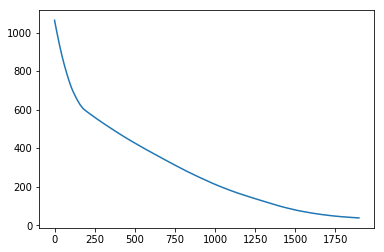

In [7]:
if __name__ == '__main__':
    data_path = './train_data.csv'
    train_data = pd.DataFrame(pd.read_csv(data_path))
    # print(train_data)

    model = cHawk(train_data)
    # print(model.intensity(i=41976, d=6, t=64))
    # print(model.grad())

    model.optimize()
    # print(model.grad())
    model.draw()
    model.save()

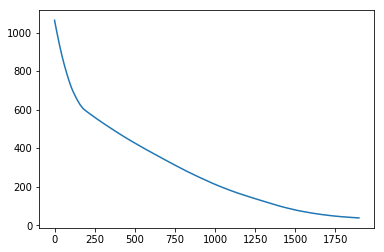

0.947355795971915
0.9220903416053694
0.9375622806133563
0.6572199146203525
0.9375623367441301
0.9375622735853408
0.7245054936497769
0.9733194958991134
1.0
0.9477763893855621
0.9733192046658714
0.9375622935277251


0.9717937712342656
0.9579948539017665
0.9792972609768553
0.9593468113670482
0.22890534257375092
0.979297258594876
0.9007121451127065
0.9857946450455118
1.0
0.9720221917417581
0.9857944889918083
0.9792972653538746


0.9843939273216173
0.976684945407317
0.9941457461252642
0.9884193752478475
0.9941457515455863
0.9941457454465971
0.9710778118077112
0.9921655254390266
1.0
0.984521121858377
0.2873607636443696
0.9941457473723526


0.976405842548576
0.9648220742198508
0.2621206571113057
0.5239138520555702
0.9815068896079977
0.9815068704648815
0.9109165849103528
0.9881313616368186
1.0
0.9765973645723
0.9881312310984648
0.9815068765093194


0.8856025785278183
0.8334256090408555
0.9042308303320664
0.8189622352757688
0.9042309148621226
0.904230819748237
0.6098044024485626
0.9410590701128

In [8]:
data_path = './train_data.csv'
train_data = pd.DataFrame(pd.read_csv(data_path))
# print(train_data)
# exit(0)
model = cHawk(train_data)
model.load()
model.draw()
pred = model.predict()
print(model.A)
print(model.u)

In [9]:
pred

{41795: 8,
 43881: 8,
 42346: 8,
 44083: 8,
 40310: 8,
 42135: 8,
 41976: 8,
 40124: 8}

In [10]:
model.A[0][0]

0.0